In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import torch
from torch import nn
import os


data = pd.read_csv('/kaggle/input/apple-dataset/aapl.csv')

In [2]:
data = data[2:]

In [3]:
data.head()

,Price,Close,High,Low,Open,Volume
2,1980-12-12,0.09872590750455856,0.09915512675954263,0.09872590750455856,0.09872590750455856,469033600
3,1980-12-15,0.09357531368732452,0.0940045329291232,0.09357531368732452,0.0940045329291232,175884800
4,1980-12-16,0.08670709282159805,0.08713630637747925,0.08670709282159805,0.08713630637747925,105728000
5,1980-12-17,0.08885321021080017,0.08928242968198377,0.08885321021080017,0.08885321021080017,86441600
6,1980-12-18,0.09142924100160599,0.09185845454209865,0.09142924100160599,0.09142924100160599,73449600


In [4]:
prices = data['Close'].to_numpy(dtype='float32')

In [5]:
prices[0:5]

array([0.09872591, 0.09357531, 0.08670709, 0.08885321, 0.09142924],
      dtype=float32)

In [6]:
def df_to_X_y(df = data, window_size = 60):
    X = []
    y = []

    for i in range(len(df)-window_size):
        row = [[a] for a in df[i:i+window_size]]
        X.append(row)

        label = df[i+window_size]
        y.append(label)

    return np.array(X), np.array(y)

X, y = df_to_X_y(prices, 60)
# we can also use shift function

In [7]:
print(len(X), len(y))
print(X[0:2], y[0:5])

11113 11113
[[[0.09872591]
  [0.09357531]
  [0.08670709]
  [0.08885321]
  [0.09142924]
  [0.09700905]
  [0.10173041]
  [0.10602336]
  [0.1116032 ]
  [0.12190518]
  [0.12362198]
  [0.12061751]
  [0.11718376]
  [0.11847146]
  [0.11589614]
  [0.11074476]
  [0.10602336]
  [0.1038773 ]
  [0.10945704]
  [0.10859868]
  [0.10473573]
  [0.10516495]
  [0.10731103]
  [0.10645258]
  [0.11289081]
  [0.10945704]
  [0.1116032 ]
  [0.11289081]
  [0.11246159]
  [0.11074476]
  [0.10988639]
  [0.10645258]
  [0.10258964]
  [0.09700905]
  [0.09142924]
  [0.09486298]
  [0.0982967 ]
  [0.0982967 ]
  [0.09872591]
  [0.09357531]
  [0.09357531]
  [0.09057077]
  [0.08971158]
  [0.08756555]
  [0.08971158]
  [0.09357531]
  [0.08799476]
  [0.08327337]
  [0.08456101]
  [0.08155651]
  [0.08670709]
  [0.08799476]
  [0.09100006]
  [0.09142924]
  [0.09014159]
  [0.08928237]
  [0.08885321]
  [0.08799476]
  [0.08112729]
  [0.07726359]]

 [[0.09357531]
  [0.08670709]
  [0.08885321]
  [0.09142924]
  [0.09700905]
  [0.101730

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8890, 60, 1), (8890,), (2223, 60, 1), (2223,))

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Reshape for scaler: merge batch and time dimension
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Scale
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.transform(X_test_reshaped)

# Reshape back to original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)


y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

In [11]:
X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape

((8890, 60, 1), (8890, 1), (2223, 60, 1), (2223, 1))

In [12]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [13]:
# Defining the LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)
    

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        
        last_hidden_state = lstm_out[:, -1, :]

        output = self.fc(last_hidden_state)

        return output

In [14]:
input_size = 1
hidden_size = 64
num_layers = 3
learning_rate = 0.01
num_epochs = 50

In [15]:
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# This will work for CPU or GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
# del X
# del y
# del X_tensor
# del y_tensor
# del data
# del prices
# del scaled_data
# del scaler
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [19]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [20]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    torch.cuda.empty_cache()

    if (epoch + 1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [10/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000


In [21]:
model.eval()

with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f"Test loss: {test_loss.item():.4f}")

Test loss: 0.0001


In [52]:
# Convert back to numpy and inverse transform
preds_inverse = y_scaler.inverse_transform(predictions.cpu().numpy())
y_test_inverse = y_scaler.inverse_transform(y_test_tensor.cpu().numpy())

# Convert back to tensors
preds_tensor = torch.tensor(preds_inverse)
actual_tensor = torch.tensor(y_test_inverse)

# Calculate MSE on original values
mse_criterion = nn.MSELoss()
mse = mse_criterion(preds_tensor, actual_tensor)

print(f"Real MSE (original scale): {mse.item():.4f}")


Real MSE (original scale): 5.1125


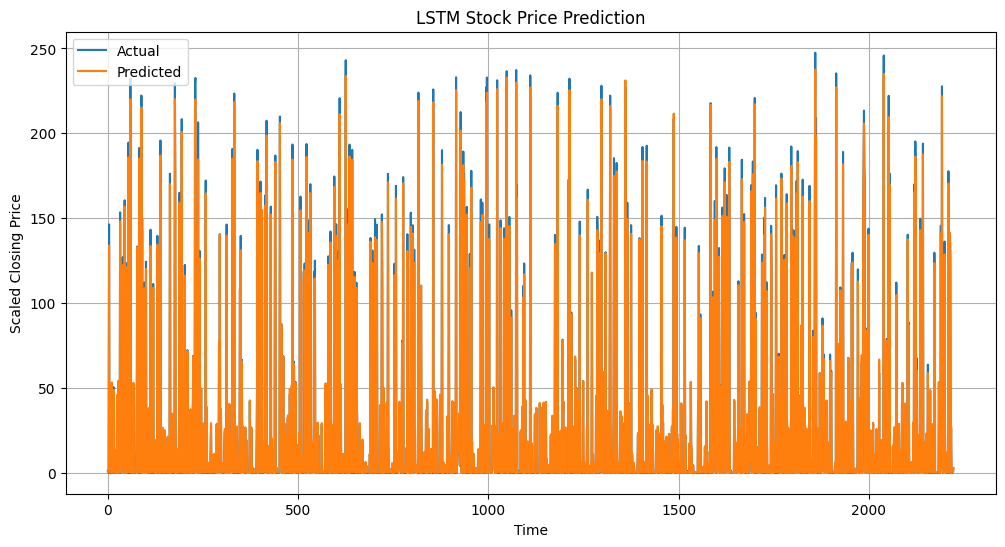

In [22]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
preds = predictions.squeeze().cpu().numpy()
actual = y_test_tensor.squeeze().cpu().numpy()

preds = preds.reshape(-1, 1)
actual = actual.reshape(-1, 1)

preds = y_scaler.inverse_transform(preds)
actual = y_scaler.inverse_transform(actual)

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(preds, label='Predicted')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.grid(True)
plt.show()

